# Load Test Results Analysis

This notebook analyzes the results from video processing load tests at different concurrency levels.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from pathlib import Path

# Style configuration
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Color palette
COLORS = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']


## Load and Process Data


In [2]:
def extract_concurrency(filename):
    """Extract concurrency level from filename like 'load_test_20260102_024910_2.csv'"""
    match = re.search(r'_(\d+)\.csv$', filename)
    return int(match.group(1)) if match else None

def load_all_results(pattern='load_test_*.csv', discard_first_half=True):
    """Load all load test CSV files and combine them
    
    Args:
        pattern: glob pattern to match files
        discard_first_half: if True, discard the first half of records from each file
                           (to exclude autoscaling warm-up period with high latencies)
    """
    all_files = glob.glob(pattern)
    print(f"Found {len(all_files)} load test files")
    
    dfs = []
    for file in sorted(all_files):
        concurrency = extract_concurrency(file)
        if concurrency:
            df = pd.read_csv(file)
            original_len = len(df)
            
            # Discard first half to exclude autoscaling warm-up
            if discard_first_half:
                df = df.iloc[len(df)//2:].reset_index(drop=True)
            
            df['concurrency'] = concurrency
            df['filename'] = Path(file).name
            dfs.append(df)
            print(f"  Loaded {file}: {len(df)}/{original_len} requests (kept 2nd half), concurrency={concurrency}")
    
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Load all data (discarding first half to exclude autoscaling warm-up)
df = load_all_results(discard_first_half=True)
print(f"\nTotal requests loaded: {len(df):,}")


Found 6 load test files
  Loaded load_test_20260106_073125_2.csv: 152/303 requests (kept 2nd half), concurrency=2
  Loaded load_test_20260106_073340_4.csv: 590/1180 requests (kept 2nd half), concurrency=4
  Loaded load_test_20260106_073909_8.csv: 1103/2206 requests (kept 2nd half), concurrency=8
  Loaded load_test_20260106_074419_16.csv: 2240/4480 requests (kept 2nd half), concurrency=16
  Loaded load_test_20260106_074908_32.csv: 4141/8282 requests (kept 2nd half), concurrency=32
  Loaded load_test_20260106_075355_64.csv: 17283/34565 requests (kept 2nd half), concurrency=64

Total requests loaded: 25,509


In [3]:
# Data overview
print("Columns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nConcurrency levels tested:", sorted(df['concurrency'].unique()))


Columns: ['request_id', 'stream_id', 'start_time', 'end_time', 'latency_ms', 'success', 'status_code', 'error', 's3_download_ms', 'decode_video_ms', 'encode_ms', 'decode_ms', 'server_total_ms', 'num_chunks', 'video_duration', 'num_scene_changes', 'concurrency', 'filename']

Data types:
request_id            object
stream_id             object
start_time           float64
end_time             float64
latency_ms           float64
success                 bool
status_code            int64
error                float64
s3_download_ms       float64
decode_video_ms      float64
encode_ms            float64
decode_ms            float64
server_total_ms      float64
num_chunks             int64
video_duration       float64
num_scene_changes      int64
concurrency            int64
filename              object
dtype: object

Concurrency levels tested: [2, 4, 8, 16, 32, 64]


In [4]:
df.head(10)


,request_id,stream_id,start_time,end_time,latency_ms,success,status_code,error,s3_download_ms,decode_video_ms,encode_ms,decode_ms,server_total_ms,num_chunks,video_duration,num_scene_changes,concurrency,filename
0,req_000152,a9fc8b25,1.767685e+09,1.767685e+09,830.992801,True,200,NaN,85.38,97.35,0.11,640.34,823.34,1,8.266667,0,2,load_test_20260106_073125_2.csv
1,req_000153,0fd014f1,1.767685e+09,1.767685e+09,827.173530,True,200,NaN,71.43,94.89,0.07,653.50,820.05,1,8.266667,0,2,load_test_20260106_073125_2.csv
2,req_000154,cfde0089,1.767685e+09,1.767685e+09,829.954547,True,200,NaN,75.72,95.05,0.13,651.07,822.12,1,8.266667,0,2,load_test_20260106_073125_2.csv
3,req_000155,3c4db4f0,1.767685e+09,1.767685e+09,830.896046,True,200,NaN,73.82,96.75,0.09,652.99,823.81,1,8.266667,0,2,load_test_20260106_073125_2.csv
4,req_000156,f357b8b9,1.767685e+09,1.767685e+09,827.621177,True,200,NaN,70.03,96.12,0.10,654.13,820.52,1,8.266667,0,2,load_test_20260106_073125_2.csv
5,req_000157,ba0cd020,1.767685e+09,1.767685e+09,829.573831,True,200,NaN,78.38,94.37,0.07,649.43,822.39,1,8.266667,0,2,load_test_20260106_073125_2.csv
6,req_000158,de6b1489,1.767685e+09,1.767685e+09,829.757153,True,200,NaN,75.54,91.39,0.06,655.13,822.28,1,8.266667,0,2,load_test_20260106_073125_2.csv
7,req_000159,bec556e7,1.767685e+09,1.767685e+09,832.013772,True,200,NaN,72.38,90.52,0.07,661.57,824.71,1,8.266667,0,2,load_test_20260106_073125_2.csv
8,req_000160,0cb65a02,1.767685e+09,1.767685e+09,830.258047,True,200,NaN,66.93,97.82,0.10,657.43,822.43,1,8.266667,0,2,load_test_20260106_073125_2.csv
9,req_000161,04e15e64,1.767685e+09,1.767685e+09,827.440291,True,200,NaN,65.44,95.93,0.09,658.56,820.17,1,8.266667,0,2,load_test_20260106_073125_2.csv


## Summary Statistics by Concurrency


In [5]:
def compute_stats(group):
    """Compute summary statistics for a group of requests"""
    latency = group['latency_ms']
    duration = group['end_time'].max() - group['start_time'].min()
    
    return pd.Series({
        'total_requests': len(group),
        'success_count': group['success'].sum(),
        'success_rate_%': group['success'].mean() * 100,
        'latency_mean_ms': latency.mean(),
        'latency_std_ms': latency.std(),
        'latency_min_ms': latency.min(),
        'latency_p50_ms': latency.quantile(0.5),
        'latency_p90_ms': latency.quantile(0.9),
        'latency_p95_ms': latency.quantile(0.95),
        'latency_p99_ms': latency.quantile(0.99),
        'latency_max_ms': latency.max(),
        'test_duration_s': duration,
        'throughput_rps': len(group) / duration if duration > 0 else 0,
    })

# Compute statistics by concurrency
stats_by_concurrency = df.groupby('concurrency').apply(compute_stats).reset_index()
stats_by_concurrency = stats_by_concurrency.sort_values('concurrency')

# Display formatted
display_cols = ['concurrency', 'total_requests', 'success_rate_%', 
                'latency_mean_ms', 'latency_p50_ms', 'latency_p95_ms', 'latency_p99_ms',
                'throughput_rps']
stats_by_concurrency[display_cols].round(2)


/tmp/ipykernel_239765/1135953997.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_concurrency = df.groupby('concurrency').apply(compute_stats).reset_index()


,concurrency,total_requests,success_rate_%,latency_mean_ms,latency_p50_ms,latency_p95_ms,latency_p99_ms,throughput_rps
0,2,152.0,100.0,837.09,837.94,842.70,844.29,2.37
1,4,590.0,100.0,850.57,857.60,984.36,1025.04,4.68
2,8,1103.0,100.0,885.63,885.07,1065.04,1119.52,8.97
3,16,2240.0,100.0,893.49,900.28,1074.40,1128.48,17.78
4,32,4141.0,100.0,913.36,928.13,1095.00,1150.93,34.75
5,64,17283.0,100.0,943.04,966.70,1128.04,1187.63,67.55


## Latency Distribution Analysis


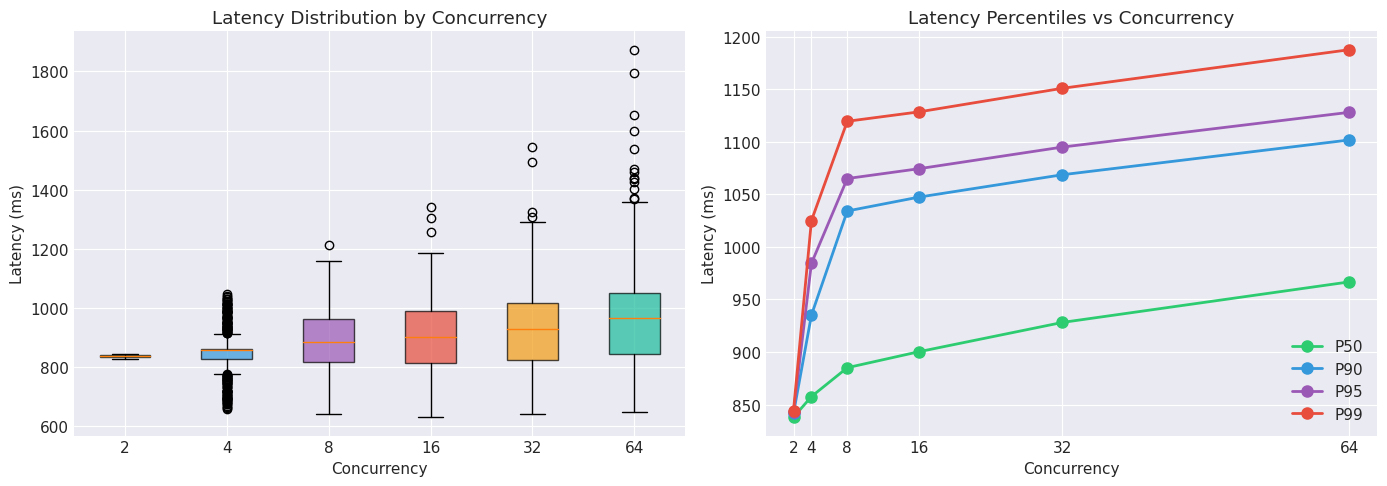

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

concurrencies = sorted(df['concurrency'].unique())

# Box plot of latencies
ax1 = axes[0]
data_for_box = [df[df['concurrency'] == c]['latency_ms'].values for c in concurrencies]
bp = ax1.boxplot(data_for_box, labels=concurrencies, patch_artist=True)
for patch, color in zip(bp['boxes'], COLORS[:len(concurrencies)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_xlabel('Concurrency')
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Latency Distribution by Concurrency')

# Latency percentiles line chart
ax2 = axes[1]
percentiles = ['latency_p50_ms', 'latency_p90_ms', 'latency_p95_ms', 'latency_p99_ms']
labels = ['P50', 'P90', 'P95', 'P99']
for i, (p, label) in enumerate(zip(percentiles, labels)):
    ax2.plot(stats_by_concurrency['concurrency'], stats_by_concurrency[p], 
             marker='o', label=label, color=COLORS[i], linewidth=2, markersize=8)
ax2.set_xlabel('Concurrency')
ax2.set_ylabel('Latency (ms)')
ax2.set_title('Latency Percentiles vs Concurrency')
ax2.legend()
ax2.set_xticks(concurrencies)

plt.tight_layout()
fig.savefig('assets/latency_distribution_by_concurrency.png', dpi=150, bbox_inches='tight')
plt.show()


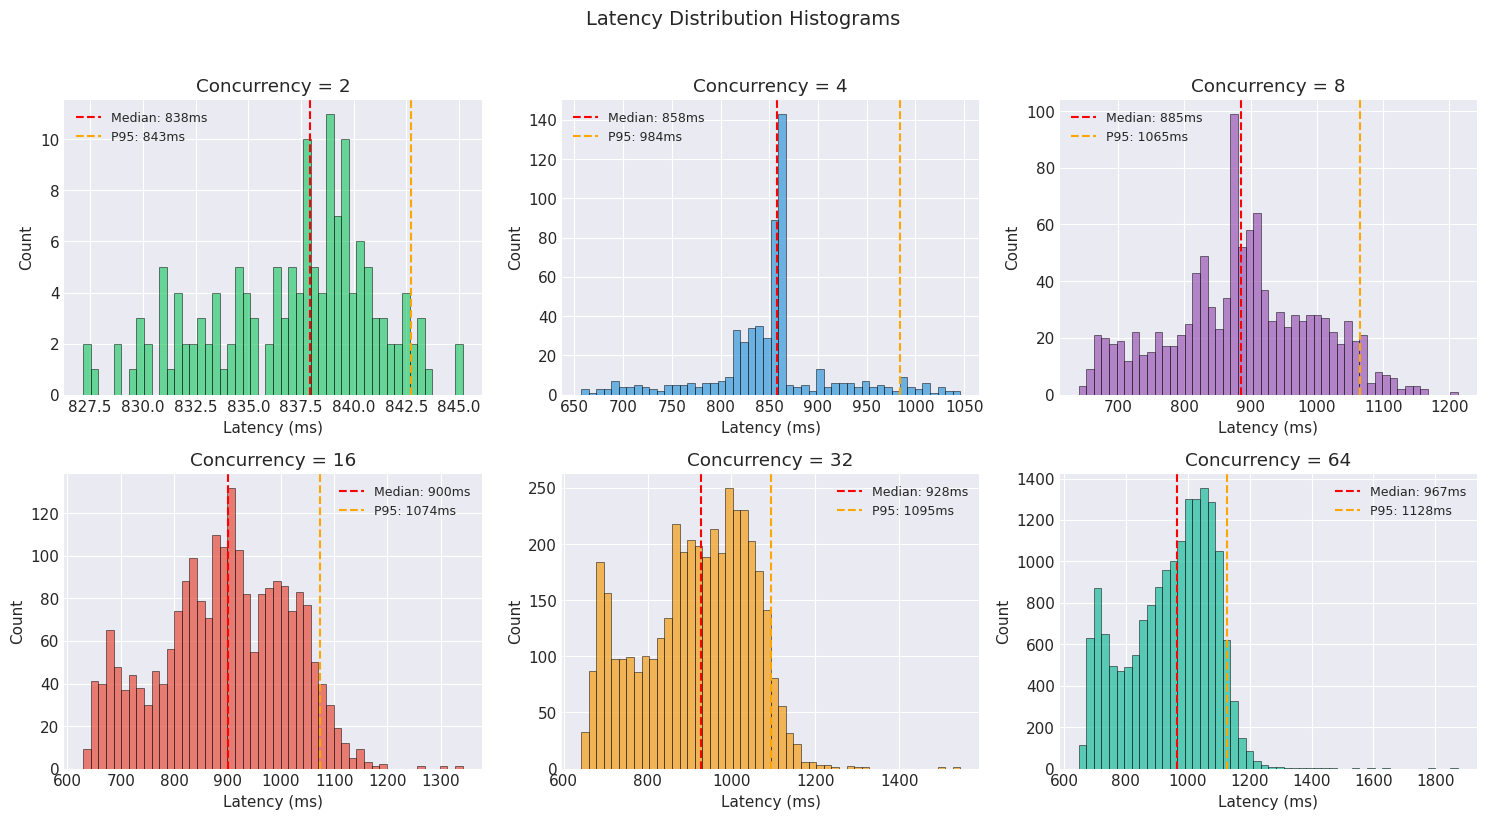

In [7]:
# Histogram of latencies for each concurrency
n_concurrencies = len(concurrencies)
n_cols = min(3, n_concurrencies)
n_rows = (n_concurrencies + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_concurrencies == 1:
    axes = np.array([axes])
axes = axes.flatten()

for i, (c, color) in enumerate(zip(concurrencies, COLORS)):
    ax = axes[i]
    data = df[df['concurrency'] == c]['latency_ms']
    ax.hist(data, bins=50, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(data.median(), color='red', linestyle='--', label=f'Median: {data.median():.0f}ms')
    ax.axvline(data.quantile(0.95), color='orange', linestyle='--', label=f'P95: {data.quantile(0.95):.0f}ms')
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Count')
    ax.set_title(f'Concurrency = {c}')
    ax.legend(fontsize=9)

# Hide unused subplots
for i in range(len(concurrencies), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Latency Distribution Histograms', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig('assets/latency_histograms.png', dpi=150, bbox_inches='tight')
plt.show()


## Throughput Analysis


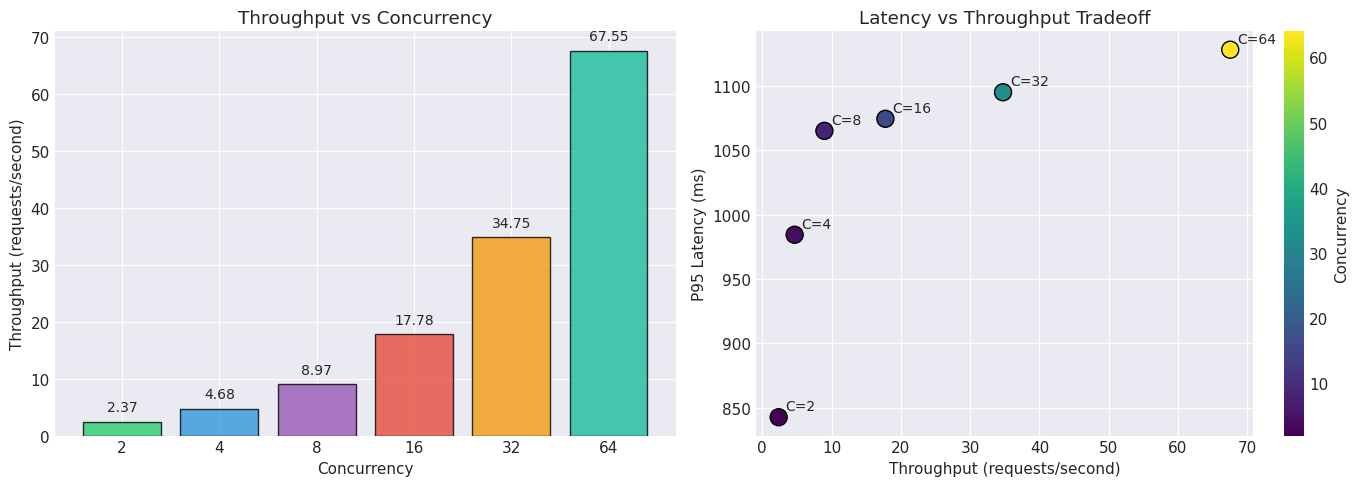

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Throughput vs Concurrency
ax1 = axes[0]
ax1.bar(stats_by_concurrency['concurrency'].astype(str), 
        stats_by_concurrency['throughput_rps'],
        color=COLORS[:len(concurrencies)], alpha=0.8, edgecolor='black')
ax1.set_xlabel('Concurrency')
ax1.set_ylabel('Throughput (requests/second)')
ax1.set_title('Throughput vs Concurrency')

# Add value labels on bars
for i, (c, v) in enumerate(zip(stats_by_concurrency['concurrency'], stats_by_concurrency['throughput_rps'])):
    ax1.text(i, v + 0.02 * max(stats_by_concurrency['throughput_rps']), 
             f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Latency vs Throughput tradeoff
ax2 = axes[1]
scatter = ax2.scatter(stats_by_concurrency['throughput_rps'], 
                      stats_by_concurrency['latency_p95_ms'],
                      c=stats_by_concurrency['concurrency'], 
                      s=150, cmap='viridis', edgecolors='black', linewidth=1)
for _, row in stats_by_concurrency.iterrows():
    ax2.annotate(f"C={int(row['concurrency'])}", 
                 (row['throughput_rps'], row['latency_p95_ms']),
                 textcoords="offset points", xytext=(5, 5), fontsize=10)
ax2.set_xlabel('Throughput (requests/second)')
ax2.set_ylabel('P95 Latency (ms)')
ax2.set_title('Latency vs Throughput Tradeoff')
plt.colorbar(scatter, ax=ax2, label='Concurrency')

plt.tight_layout()
fig.savefig('assets/throughput_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


## Processing Time Breakdown


In [9]:
# Compute mean processing times by concurrency
time_components = ['s3_download_ms', 'decode_video_ms', 'encode_ms', 'decode_ms']
available_components = [c for c in time_components if c in df.columns]

time_breakdown = df.groupby('concurrency')[available_components].mean()
time_breakdown = time_breakdown.sort_index()
print("Mean Processing Time Breakdown (ms):")
time_breakdown.round(2)


Mean Processing Time Breakdown (ms):


,s3_download_ms,decode_video_ms,encode_ms,decode_ms
concurrency,,,,
2,76.48,96.73,0.09,656.27
4,76.28,97.13,0.09,669.14
8,76.08,94.84,0.08,706.52
16,76.84,93.34,0.08,715.14
32,76.43,95.31,0.08,731.83
64,76.61,97.63,0.09,757.13


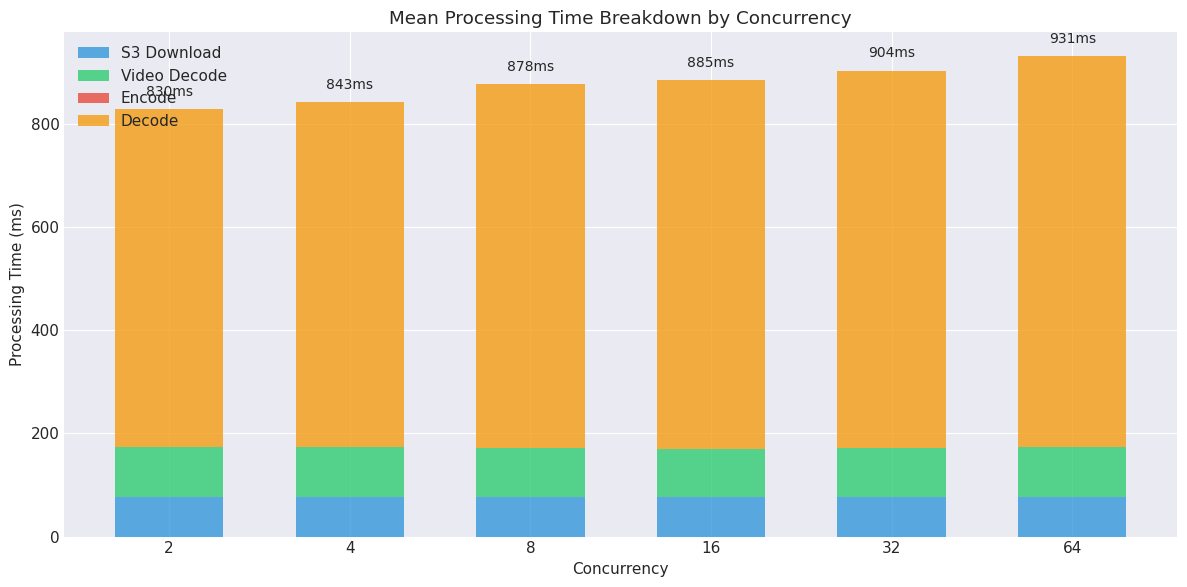

In [10]:
# Stacked bar chart of processing time components
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(time_breakdown))
width = 0.6
bottom = np.zeros(len(time_breakdown))

component_colors = {'s3_download_ms': '#3498db', 'decode_video_ms': '#2ecc71', 
                    'encode_ms': '#e74c3c', 'decode_ms': '#f39c12'}
component_labels = {'s3_download_ms': 'S3 Download', 'decode_video_ms': 'Video Decode', 
                    'encode_ms': 'Encode', 'decode_ms': 'Decode'}

for component in available_components:
    values = time_breakdown[component].values
    ax.bar(x, values, width, label=component_labels.get(component, component), 
           bottom=bottom, color=component_colors.get(component, '#95a5a6'), alpha=0.8)
    bottom += values

ax.set_xlabel('Concurrency')
ax.set_ylabel('Processing Time (ms)')
ax.set_title('Mean Processing Time Breakdown by Concurrency')
ax.set_xticks(x)
ax.set_xticklabels(time_breakdown.index)
ax.legend(loc='upper left')

# Add total time labels
for i, total in enumerate(bottom):
    ax.text(i, total + 20, f'{total:.0f}ms', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
fig.savefig('assets/processing_time_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()


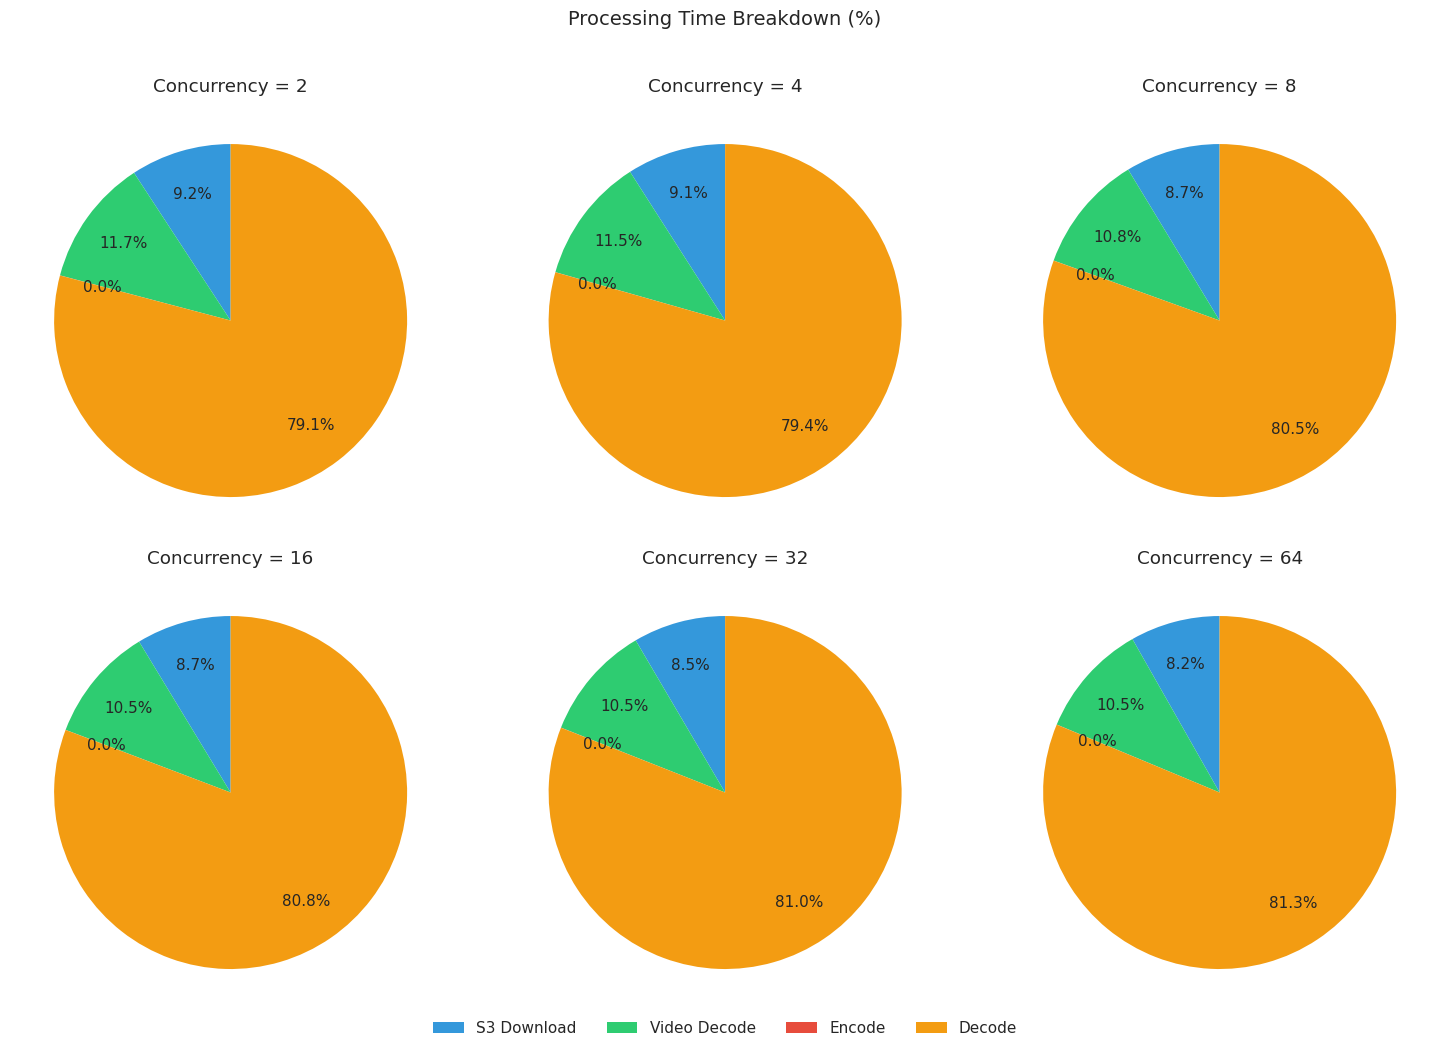

In [11]:
# Processing time component percentage breakdown
n_cols = min(3, len(concurrencies))
n_rows = (len(concurrencies) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
if len(concurrencies) == 1:
    axes = np.array([axes])
axes = axes.flatten()

for i, c in enumerate(sorted(df['concurrency'].unique())):
    ax = axes[i]
    data = time_breakdown.loc[c]
    colors = [component_colors.get(comp, '#95a5a6') for comp in available_components]
    labels = [component_labels.get(comp, comp) for comp in available_components]
    
    wedges, texts, autotexts = ax.pie(data, colors=colors, autopct='%1.1f%%', 
                                       startangle=90, pctdistance=0.75)
    ax.set_title(f'Concurrency = {c}')
    
for i in range(len(concurrencies), len(axes)):
    axes[i].set_visible(False)

# Add legend
labels = [component_labels.get(comp, comp) for comp in available_components]
fig.legend(labels, loc='lower center', ncol=len(available_components), bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Processing Time Breakdown (%)', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig('assets/processing_time_pie_charts.png', dpi=150, bbox_inches='tight')
plt.show()


## Request Timeline Analysis


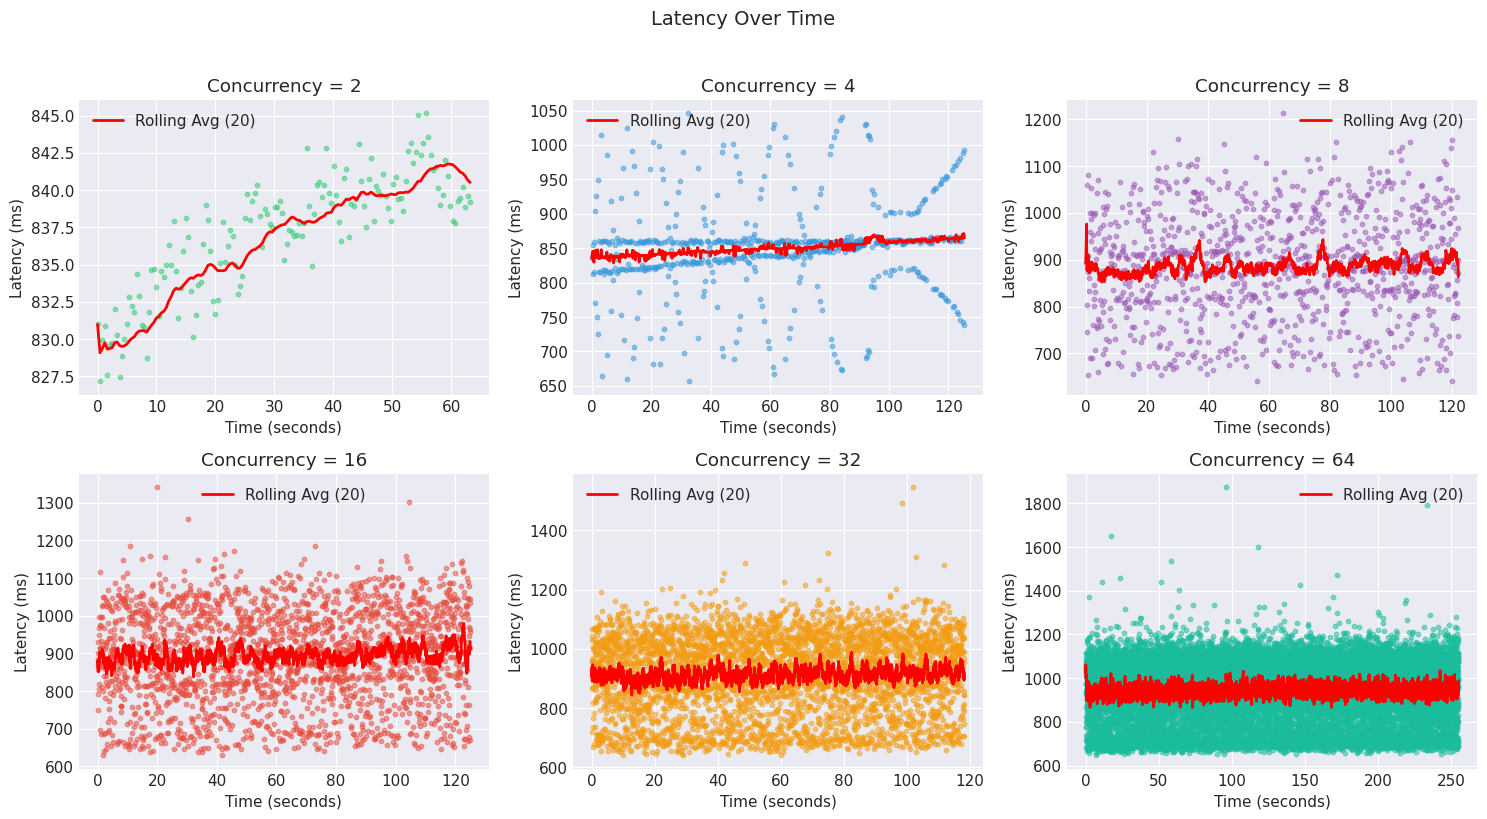

In [12]:
# Time series of latency during the test
n_cols = min(3, len(concurrencies))
n_rows = (len(concurrencies) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if len(concurrencies) == 1:
    axes = np.array([axes])
axes = axes.flatten()

for i, (c, color) in enumerate(zip(concurrencies, COLORS)):
    ax = axes[i]
    data = df[df['concurrency'] == c].copy()
    data['relative_time'] = data['start_time'] - data['start_time'].min()
    
    ax.scatter(data['relative_time'], data['latency_ms'], alpha=0.5, s=10, color=color)
    
    # Rolling average
    if len(data) > 20:
        rolling = data.sort_values('relative_time')['latency_ms'].rolling(window=20, min_periods=1).mean()
        ax.plot(data.sort_values('relative_time')['relative_time'], rolling, 
                color='red', linewidth=2, label='Rolling Avg (20)')
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Concurrency = {c}')
    ax.legend()

for i in range(len(concurrencies), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Latency Over Time', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig('assets/latency_over_time.png', dpi=150, bbox_inches='tight')
plt.show()


## Error Analysis


In [13]:
# Check for failed requests
failed = df[df['success'] == False]
print(f"Total failed requests: {len(failed)} ({len(failed)/len(df)*100:.2f}%)")

if len(failed) > 0:
    print("\nFailure breakdown by concurrency:")
    failure_stats = df.groupby('concurrency').agg(
        total=('success', 'count'),
        failures=('success', lambda x: (~x).sum()),
        failure_rate=('success', lambda x: (~x).mean() * 100)
    )
    print(failure_stats)
    
    if 'error' in failed.columns:
        print("\nError types:")
        print(failed['error'].value_counts())
    
    if 'status_code' in failed.columns:
        print("\nStatus codes for failures:")
        print(failed['status_code'].value_counts())
else:
    print("\n✅ All requests succeeded!")


Total failed requests: 0 (0.00%)

✅ All requests succeeded!


## Summary Report


In [14]:
print("=" * 70)
print("LOAD TEST SUMMARY REPORT")
print("=" * 70)

print(f"\n📊 Test Overview:")
print(f"   Total requests analyzed: {len(df):,}")
print(f"   Concurrency levels tested: {sorted(concurrencies)}")
print(f"   Overall success rate: {df['success'].mean()*100:.2f}%")

print(f"\n⚡ Performance Highlights:")
best_throughput = stats_by_concurrency.loc[stats_by_concurrency['throughput_rps'].idxmax()]
print(f"   Best throughput: {best_throughput['throughput_rps']:.2f} req/s at concurrency {int(best_throughput['concurrency'])}")

best_latency = stats_by_concurrency.loc[stats_by_concurrency['latency_p95_ms'].idxmin()]
print(f"   Best P95 latency: {best_latency['latency_p95_ms']:.0f}ms at concurrency {int(best_latency['concurrency'])}")

print(f"\n📈 Latency by Concurrency:")
for _, row in stats_by_concurrency.iterrows():
    print(f"   C={int(row['concurrency']):2d}: P50={row['latency_p50_ms']:7.0f}ms, "
          f"P95={row['latency_p95_ms']:7.0f}ms, P99={row['latency_p99_ms']:7.0f}ms, "
          f"Throughput={row['throughput_rps']:.2f} req/s")

print(f"\n🔧 Processing Time Breakdown (mean at best throughput concurrency):")
best_c = int(best_throughput['concurrency'])
for comp in available_components:
    mean_time = df[df['concurrency'] == best_c][comp].mean()
    print(f"   {component_labels.get(comp, comp)}: {mean_time:.2f}ms")

print("\n" + "=" * 70)


LOAD TEST SUMMARY REPORT

📊 Test Overview:
   Total requests analyzed: 25,509
   Concurrency levels tested: [2, 4, 8, 16, 32, 64]
   Overall success rate: 100.00%

⚡ Performance Highlights:
   Best throughput: 67.55 req/s at concurrency 64
   Best P95 latency: 843ms at concurrency 2

📈 Latency by Concurrency:
   C= 2: P50=    838ms, P95=    843ms, P99=    844ms, Throughput=2.37 req/s
   C= 4: P50=    858ms, P95=    984ms, P99=   1025ms, Throughput=4.68 req/s
   C= 8: P50=    885ms, P95=   1065ms, P99=   1120ms, Throughput=8.97 req/s
   C=16: P50=    900ms, P95=   1074ms, P99=   1128ms, Throughput=17.78 req/s
   C=32: P50=    928ms, P95=   1095ms, P99=   1151ms, Throughput=34.75 req/s
   C=64: P50=    967ms, P95=   1128ms, P99=   1188ms, Throughput=67.55 req/s

🔧 Processing Time Breakdown (mean at best throughput concurrency):
   S3 Download: 76.61ms
   Video Decode: 97.63ms
   Encode: 0.09ms
   Decode: 757.13ms



In [15]:
# Final comparison table
final_table = stats_by_concurrency[['concurrency', 'total_requests', 'success_rate_%',
                                     'latency_mean_ms', 'latency_p50_ms', 'latency_p95_ms', 
                                     'latency_p99_ms', 'throughput_rps']].copy()
final_table.columns = ['Concurrency', 'Requests', 'Success %', 
                       'Mean (ms)', 'P50 (ms)', 'P95 (ms)', 'P99 (ms)', 'Throughput (rps)']
final_table = final_table.round(2)
final_table


,Concurrency,Requests,Success %,Mean (ms),P50 (ms),P95 (ms),P99 (ms),Throughput (rps)
0,2,152.0,100.0,837.09,837.94,842.70,844.29,2.37
1,4,590.0,100.0,850.57,857.60,984.36,1025.04,4.68
2,8,1103.0,100.0,885.63,885.07,1065.04,1119.52,8.97
3,16,2240.0,100.0,893.49,900.28,1074.40,1128.48,17.78
4,32,4141.0,100.0,913.36,928.13,1095.00,1150.93,34.75
5,64,17283.0,100.0,943.04,966.70,1128.04,1187.63,67.55
